In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

from tqdm import tqdm

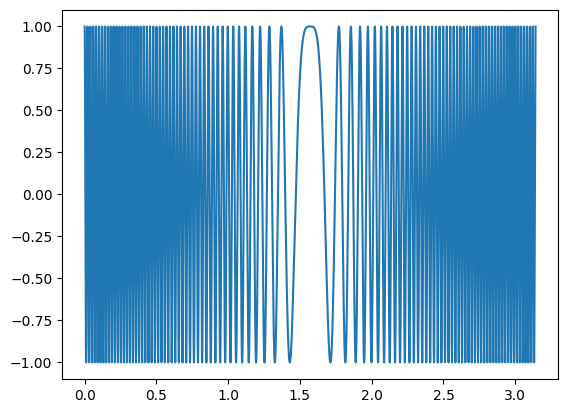

In [6]:
def test(phi, alpha=20):
    return np.cos(alpha*np.sin(phi))

phi = np.linspace(0, np.pi, 10000)
y = test(phi, alpha=50*2*np.pi)

plt.figure()

plt.plot(phi, y)

plt.show()

In [10]:
import astropy.units as u
import astropy.constants as c

In [23]:
lambda_ = 1.445 * u.Angstrom
rs = 10.5 * u.centimeter**2
g = 9.81 * u.meter/u.second**2
m = 1.675e-27 * u.kg

alpha = lambda_.to(u.meter) * rs.to(u.meter**2) * m**2 * g / (2 * np.pi * ((c.hbar).to(u.kg*u.meter**2/u.s))**2)
print(alpha)
print("N: ", 2*(np.floor(alpha/(2*np.pi))+1))
print(alpha/np.pi)

threshold = c.hbar.to(u.kg*u.meter**2/u.s)**2 *4*np.pi**2/(m**2 * g * lambda_.to(u.meter)**2)
print(threshold)

59.7617884426642
N:  20.0
19.02276807732422
763972.515106359 m


Le code présenté dans ce notebook se base sur le code d'Arturo Mena disponible sur GitHub (https://artmenlope.github.io/solving-the-2d-schrodinger-equation-using-the-crank-nicolson-method/)

In [31]:
def psi0(x, y, x0, y0, sigma=0.5, k=15*np.pi):
    return np.exp(-((x-x0)**2 + (y-y0)**2)/(4*sigma**2))*np.exp(1j*k*x)

In [97]:
# =============================================================================
# Parameters
# =============================================================================

L = 8 # Well of width L. Shafts from 0 to +L.
Dy = 0.05 # Spatial step size.
Dt = Dy**2/4 # Temporal step size.
Nx = int(L/Dy) + 1 # Number of points on the x axis.
Ny = int(L/Dy) + 1 # Number of points on the y axis.
Nt = 400 # Number of time steps.
rx = -Dt/(2j*Dy**2) # Constant to simplify expressions.
ry = -Dt/(2j*Dy**2) # Constant to simplify expressions.

# Initial position of the center of the Gaussian wave function.
x0 = L/2
y0 = L/2

In [128]:
# Parameters of the potential well
w = 3 # Width of the potential well
v0 = -1300 # Depth of the potential well

In [129]:
# Indices that parameterize the potential well in the space of points.
# Horizontal axis.
j0 = int(1/(2*Dy)*(L-w)) # Left edge.
j1 = int(1/(2*Dy)*(L+w)) # Right edge.

In [130]:
v = np.zeros((Nx, Ny), dtype=complex) # Potential.
v[:, j0:j1] = v0 # Depth of the potential well.

In [131]:
Ni = (Nx-2)*(Ny-2) #Number of unknown factors. v[i,j], i=1,...,Nx-2, j=1, ..., Ny-2

In [132]:
#Matrices for Crank-Nicolson calculus. The problem A.x[n+1]=b=M.x[n] will be solved a teach time step.
A = np.zeros((Ni, Ni), dtype=complex)
M = np.zeros((Ni, Ni), dtype=complex)

In [133]:
#We fill the matrices A and M.
for k in range(Ni):

    i = 1 + k//(Ny-2)
    j = 1 + k%(Ny-2)

    #Main central diagonal
    A[k, k] = 1 + 2*rx + 2*ry + 1j*Dt/2*v[i,j]
    M[k, k] = 1 - 2*rx - 2*ry - 1j*Dt/2*v[i,j]

    if i != 1: #Lower lone diagonal
        A[k, (i-2)*(Ny-2)+j-1] = -ry
        M[k, (i-2)*(Ny-2)+j-1] = ry

    if i != Nx-2: #Upper lone diagonal
        A[k, i*(Ny-2)+j-1] = -ry
        M[k, i*(Ny-2)+j-1] = ry

    if j != 1: #Lower central diagonal
        A[k, k-1] = -rx
        M[k, k-1] = rx
    
    if j != Ny-2: #Upper central diagonal
        A[k, k+1] = -rx
        M[k, k+1] = rx
    

In [134]:

# =============================================================================
# Second step: Solve the A·x[n+1] = M·x[n] system for each time step.
# =============================================================================

Asp = csc_matrix(A)

x = np.linspace(0, L, Ny-2) #Array of spatial points
y = np.linspace(0, L, Ny-2) #Array of spatial points
x, y = np.meshgrid(x, y)
psis = [] # To store the wave function at each time step.

psi = psi0(x, y, x0, y0) #We intialise the wave function with the Gaussian
psi[0,:] = psi[-1,:] = psi[:,0] = psi[:,-1] = 0 #Boundary conditions (Dirichlet)
psis.append(np.copy(psi))

for i in tqdm(range(1, Nt)):
    psi_vect = psi.reshape((Ni)) #Flattent the array to perform matrix multiplication
    b = np.matmul(M, psi_vect) #Compute array independant of time
    psi_vect = spsolve(Asp, b) #Solve the system
    psi = psi_vect.reshape((Nx-2, Ny-2)) #Reshape the array to its original shape
    psis.append(np.copy(psi)) #Save the result

#We compute the modulus of the wave function at each time step
mod_psis = [] #For storing the modulus of the wave function at each time step.
for wavefunc in psis:
    re = np.real(wavefunc) #Real part
    im = np.imag(wavefunc) #Imaginary part
    mod = np.sqrt(re**2 + im**2) #Calculate the modulus
    mod_psis.append(mod) #Save the calculated modulus



100%|██████████| 399/399 [02:40<00:00,  2.48it/s]


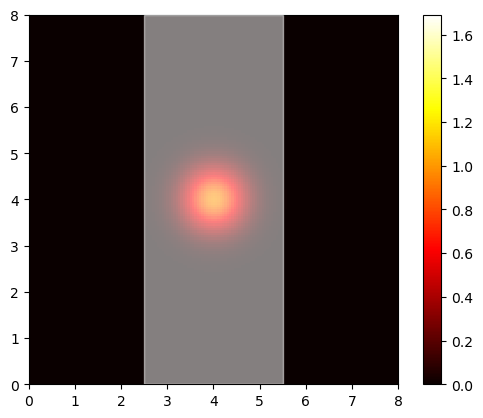

In [135]:
# =============================================================================
# Third step: We make the animation.
# =============================================================================

fig = plt.figure() #Create the figure
ax = fig.add_subplot(111, xlim=(0, L), ylim=(0, L))

img = ax.imshow(mod_psis[0]**2, extent=[0, L, 0, L], cmap=plt.get_cmap("hot"), vmin=0, vmax=np.max(mod_psis), zorder=1, interpolation="none") #Represent the modulus of the 2D wave function

#Paint the potential well
potential_well = Rectangle((j0*Dy, 0), w, L, color="w", zorder=50, alpha=0.5)

ax.add_patch(potential_well)

def animate(i):
    """
    Animation function. Paints each frame. Function for Matplotlib's FuncAnim
    """

    img.set_data(mod_psis[i]**2) #Fill img with the modulus data of the wave function.

    return img #We return the result ready to use with blit=True

anim = FuncAnimation(fig, animate, interval=1, frames=np.arange(0, Nt, 2), repeat=False, blit=False)

cbar = plt.colorbar(img)
plt.show()

In [136]:
anim.save("wavefunction_deep_potential.mp4", fps=60, writer="ffmpeg")

In [137]:
from IPython.display import Video

Video("wavefunction_deep_potential.mp4")